# Roadmap

  1. Find Available NEXRAD Data
  2. Download NEXRAD Data
  3. Inspect Radar Data
  4. Mask bad data
  4. Download Sounding Data
  5. Classify Hydrometeors
  6. Compute Rainfall Estimate

## Find Available Data

First we will see what data are available for the date and site that we are interested in. 

In [61]:
ID='KTLH'
year=2016
month=9
day=2

In [62]:
import IPython

Y = '{Y:04d}'.format(Y=year)
M = '{M:02d}'.format(M=month)
D = '{D:02d}'.format(D=day)

url = 'http://www.ncdc.noaa.gov/nexradinv/bdp-download.jsp?id={ID}&yyyy={Y}&mm={M}&dd={D}&product=AAL2'.format(
       ID=ID, Y=Y, M=M, D=D)
iframe = '<iframe src='+url+' width=100% height=300></iframe>'
IPython.display.HTML(iframe)

### Option 1

Right click on the file that you want, and choose **`copy link address`**. Paste that value you just copied into a `str` called `data_url`

In [63]:
data_url = 'http://noaa-nexrad-level2.s3.amazonaws.com/2016/09/02/KTLH/KTLH20160902_022009_V06'
filename = data_url.split('/')[-1]

### Option 2

Input the hour, minute and second of the desired file

In [64]:
hour = 2
minute = 20
second = 9

In [65]:
h = '{h:02d}'.format(h=hour)
m = '{m:02d}'.format(m=minute)
s = '{s:02d}'.format(s=second)

url_root = 'http://noaa-nexrad-level2.s3.amazonaws.com'
url_dir = '/{Y}/{M}/{D}/{ID}/'.format(Y=Y, M=M, D=D, ID=ID)
filename = '{ID}{Y}{M}{D}_{h}{m}{s}_V06'.format(ID=ID, Y=Y, M=M, D=D, h=h, m=m, s=s)

data_url = url_root+url_dir+filename

## Download Data

Now that you have a valid data_url, all that is left is downloading the data.

In [66]:
import os
import wget

# path to the location where files will be stored.
cache = './tmp/'

if not os.path.isdir(cache):
    os.mkdir(cache)

if os.path.isfile(cache+filename):
    print('using cached file ...')
    path_to_file = cache+filename
else:
    print('downloading file ...')
    path_to_file = wget.download(data_url, out=cache+filename)
print(path_to_file)

using cached file ...
./tmp/KTLH20160902_022009_V06


## Read Data

Use PyART to read the data from the Volume Scan into a Radar object. 

In [67]:
import pyart
radar = pyart.io.read(path_to_file)
radar.fields.keys()

['differential_phase',
 'cross_correlation_ratio',
 'spectrum_width',
 'reflectivity',
 'differential_reflectivity',
 'velocity']

In [68]:
low_sweeps = [i for i, bool in enumerate(radar.fixed_angle['data']<.6) if bool]
radar = radar.extract_sweeps(low_sweeps)
radar.fixed_angle['data']

array([ 0.48339844,  0.48339844,  0.48339844,  0.48339844,  0.48339844,
        0.48339844,  0.48339844,  0.48339844], dtype=float32)

## Display Data 

In [69]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
display = pyart.graph.RadarDisplay(radar)

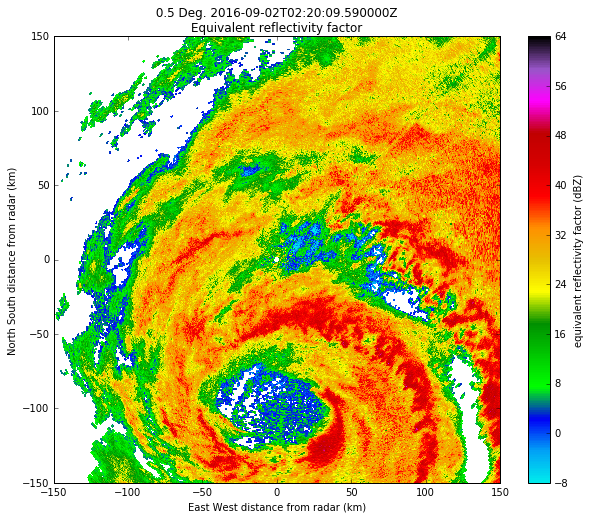

In [74]:
display.plot_ppi('reflectivity', 0, vmin=-8, vmax=64, fig=plt.figure(figsize=(10,8)))
display.set_limits((-150, 150), (-150, 150))

## Mask bad data

In [71]:
dp_sweeps = [i for i in range(radar.nsweeps) if ~radar.extract_sweeps([i]).fields['differential_phase']['data'].mask.all()]
vel_sweeps = [i for i in range(radar.nsweeps) if ~radar.extract_sweeps([i]).fields['velocity']['data'].mask.all()]

In [72]:
dp_sweeps, vel_sweeps

([0, 2, 4, 6], [1, 3, 5, 7])

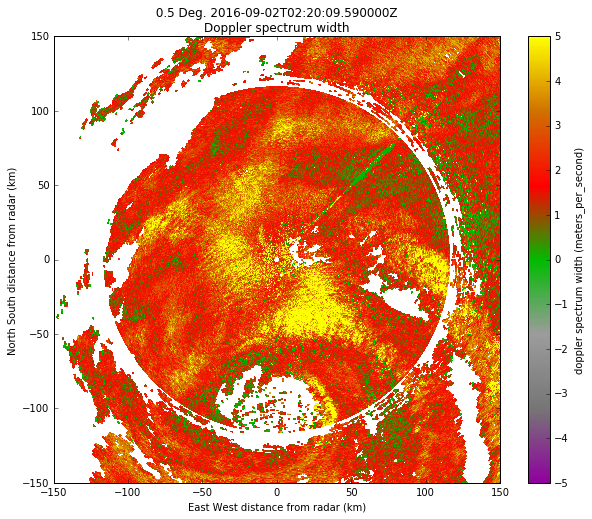

In [76]:
plt.figure(figsize=(10,8))
display.plot('spectrum_width', sweep=vel_sweeps[0], vmin=-5, vmax=5)
display.set_aspect_ratio(1)
display.set_limits((-150, 150), (-150, 150))

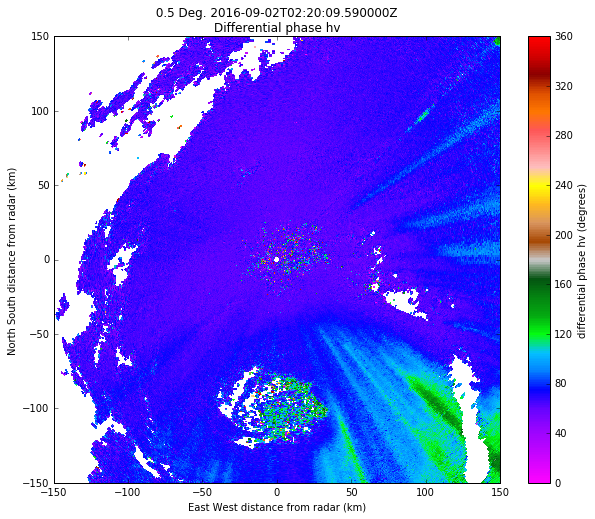

In [31]:
plt.figure(figsize=(10,8))
display.plot('differential_phase', sweep=dp_sweeps[0])
display.set_aspect_ratio(1)
display.set_limits((-150, 150), (-150, 150))

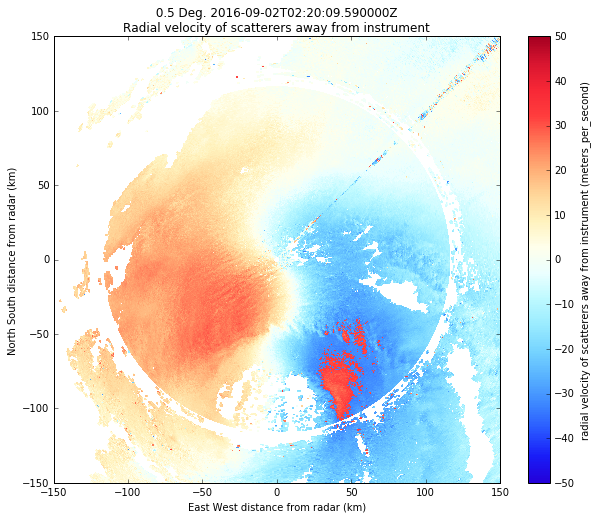

In [79]:
plt.figure(figsize=(10,8))
display.plot('velocity', sweep=vel_sweeps[2], vmin=-50, vmax=50)
display.set_aspect_ratio(1)
display.set_limits((-150, 150), (-150, 150))

In [24]:
sw = radar.fields['spectrum_width']['data']
vel = radar.fields['velocity']['data']

diff_vel = np.concatenate([np.zeros((1, vel.shape[1])), np.diff(vel, axis=0)], axis=0)
diff_vel.mask = vel.mask
radar.add_field_like('velocity', 'diff_velocity', diff_vel)

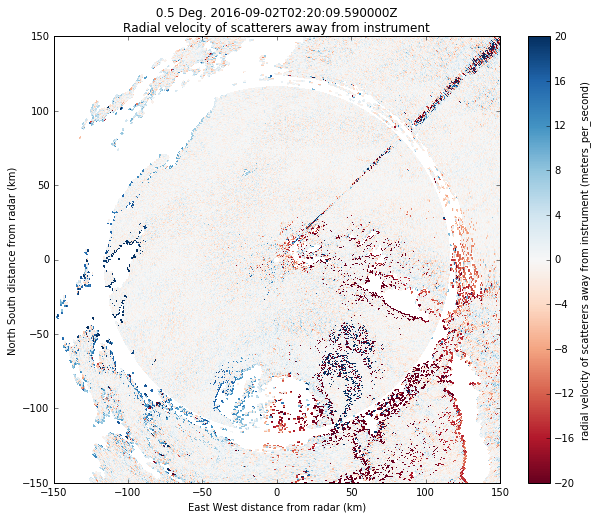

In [25]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('diff_velocity', 1, vmin=-20, vmax=20, fig=plt.figure(figsize=(10,8)), cmap='RdBu')
display.set_limits((-150, 150), (-150, 150))

## Calculate Rainfall

The display of reflectivity is nice, but sometimes we need to translate that into rainfall

In [33]:
import matplotlib.colors as colors
from pyart.io.common import radar_coords_to_cart
from skewt import SkewT
from csu_radartools import csu_fhc, csu_blended_rain, csu_dsd, csu_kdp

In [34]:
def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

dz = extract_unmasked_data(radar, 'reflectivity')
dr = extract_unmasked_data(radar, 'differential_reflectivity')
dp = extract_unmasked_data(radar, 'differential_phase')
rh = extract_unmasked_data(radar, 'cross_correlation_ratio')

# Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.
rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])

In [35]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

OK, now we have all our needed inputs to calculate Kdp. The function we will call is `csu_kdp.calc_kdp_bringi`, and it returns Kdp, filtered differential phase, and standard deviation of differential phase, in that order. Input variables can be 1D (rays) or 2D (azimuth/elevation and rays). The fundamental algorithm works on a ray-by-ray basis.

In [36]:
import time
bt = time.time()
gs = rng2d[0,1] - rng2d[0,0]
kd, fd, sd = csu_kdp.calc_kdp_bringi(
    dp=dp, dz=dz, rng=rng2d/1000.0, thsd=12, gs=gs, window=3)
print(time.time()-bt, 'seconds to run')

(2.6774849891662598, 'seconds to run')


In [37]:
radar = add_field_to_radar_object(kd, radar, field_name='KDP', units='deg/km', 
                                   long_name='Specific Differential Phase',
                                   standard_name='Specific Differential Phase', 
                                   dz_field='reflectivity')
radar = add_field_to_radar_object(fd, radar, field_name='FDP', units='deg', 
                                   long_name='Filtered Differential Phase',
                                   standard_name='Filtered Differential Phase', 
                                   dz_field='reflectivity')
radar = add_field_to_radar_object(sd, radar, field_name='SDP', units='deg', 
                                   long_name='Standard Deviation of Differential Phase',
                                   standard_name='Standard Deviation of Differential Phase', 
                                   dz_field='reflectivity')

### Sounding

Optionally you can get data from a nearby sounding in the UWyo format (i.e., from http://weather.uwyo.edu/upperair/sounding.html), and copy and paste it into a txt file. 

In [38]:
sounding = SkewT.Sounding('./tmp/sounding.txt')

In [39]:
def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']

def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    if not snd_T.mask[0]: #May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    dummy_z.append(snd_z[i])
                    dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    return snd_T, snd_z

def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z

radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)

/home/jsignell/miniconda2/envs/pyart/lib/python2.7/site-packages/pyart/exceptions.py:59: DeprecatedFunctionName: pyart.io.common.radar_coords_to_cart has been deprecated and will be removed in future versions of Py-ART, pleases use pyart.core.transforms.antenna_to_cartesian. 
  old_name, new_name), category=DeprecatedFunctionName)


In [40]:
%%time
scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, band='S', use_temp=True, T=radar_T)
fh = np.argmax(scores, axis=0) + 1

CPU times: user 27.1 s, sys: 1.73 s, total: 28.8 s
Wall time: 29 s


To enable the ability to find out the second-ranked (or third, etc.) species, `csu_fhc_summer` returns the scores for all the different categories, not just the max. So to get the traditional HID category number you have to use `numpy.argmax` as above. The summer HID from CSU returns 10 possible categories:
<ul>
<li>1. Drizzle</li>
<li>2. Rain</li>
<li>3. Ice Crystals</li>
<li>4. Aggregates</li>
<li>5. Wet/Melting Snow</li>
<li>6. Vertically Aligned Ice</li>
<li>7. Low-Density Graupel</li>
<li>8. High-Density Graupel</li>
<li>9. Hail</li>
<li>10. Big Drops</li>
</ul>

And these are represented as integers in the newly created `fh` array, which as the same structure as `dz`, `dr`, etc. We'd like to plot these data using Py-ART, which means we need to turn `fh` in a radar object field. Let's do that.

In [41]:
radar = add_field_to_radar_object(fh, radar)

In [42]:
hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)
cmapmeth = colors.ListedColormap(hid_colors[0:6])
cmapmeth_trop = colors.ListedColormap(hid_colors[0:7])

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)', 'R(Zrain)'])
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z_all)', 'R(Z_c)', 'R(Z_s)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

In [43]:
rain, method = csu_blended_rain.csu_hidro_rain(dz=dz, zdr=dr, kdp=kd, fhc=fh)
radar = add_field_to_radar_object(rain, radar, field_name='rain', units='mm h-1',
                                  long_name='HIDRO Rainfall Rate', 
                                  standard_name='Rainfall Rate')
radar = add_field_to_radar_object(method, radar, field_name='method', units='',
                                  long_name='HIDRO Rainfall Method', 
                                  standard_name='Rainfall Method')

In [44]:
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1=pyart.graph.cm.NWSRef, units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

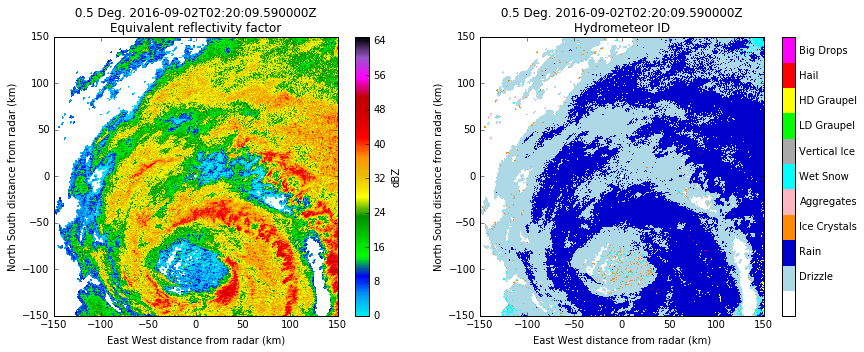

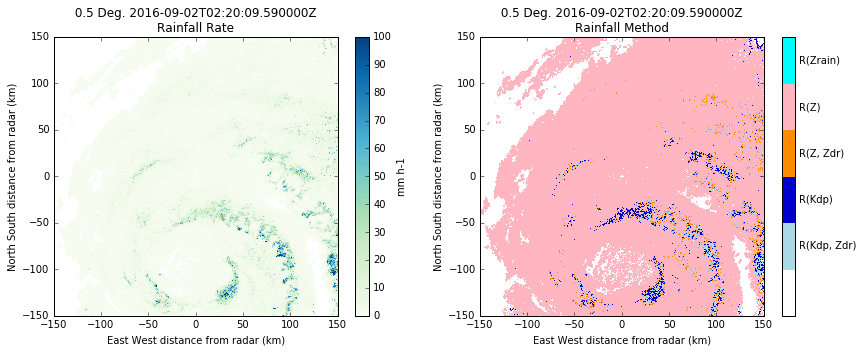

In [56]:
xlim = ylim = (-150, 150)
# reflectivity and hydrometeor classification
fig, ax1, ax2, display = two_panel_plot(radar, sweep=0, var1='reflectivity',var2='FH', 
                                        vmin2=0, vmax2=10, cmap2=cmaphid, units2='',
                                        return_flag=True, xlim=xlim, ylim=ylim)
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])

# rain rate and rain rate calculation method
fig, ax1, ax2, display = two_panel_plot(radar, sweep=0, var1='rain', vmin1=0, vmax1=100,
                                        cmap1='GnBu', var2='method', vmin2=0, vmax2=5, 
                                        cmap2=cmapmeth, units2='', return_flag=True, 
                                        xlim=xlim, ylim=ylim, units1='mm h-1')
display.cbs[1] = adjust_meth_colorbar_for_pyart(display.cbs[1])

In [57]:
rkdp = csu_blended_rain.calc_rain_kdp(kd, b=0.87)
rz = csu_blended_rain.calc_rain_nexrad(dz)
radar = add_field_to_radar_object(rkdp, radar, field_name='rkdp', units='mm h-1',  
                                  long_name='Rainfall Rate R(Kdp)', 
                                  standard_name='Rainfall Rate')
radar = add_field_to_radar_object(rz, radar, field_name='rz', units='mm h-1',
                                  long_name='Rainfall Rate R(Z)', 
                                  standard_name='Rainfall Rate')

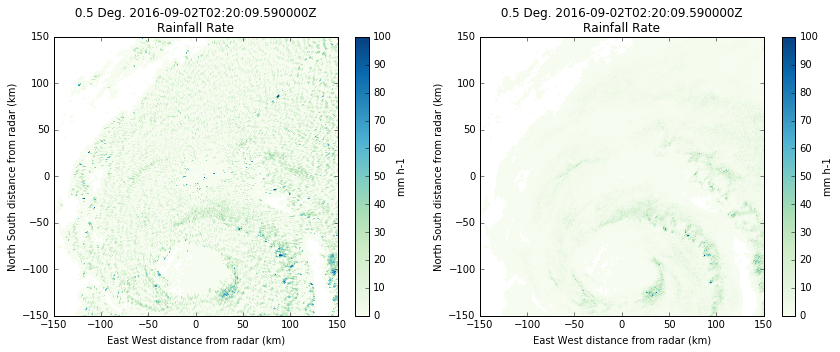

In [58]:
# rain rate and rain rate calculation method
fig, ax1, ax2, display = two_panel_plot(radar, sweep=0, var1='rkdp', vmin1=0, vmax1=100,
                                        cmap1='GnBu', var2='rz', vmin2=0, vmax2=100, 
                                        cmap2='GnBu', units2='mm h-1', return_flag=True, 
                                        xlim=xlim, ylim=ylim, units1='mm h-1')

In [59]:
rain_calc_diff = rkdp-rz
radar = add_field_to_radar_object(rain_calc_diff, radar, field_name='rain_calc_diff', units='unitless',  
                                  long_name='Rainfall Rate R(Kdp)- R(Z)', 
                                  standard_name='Difference in Rainfall Rate')

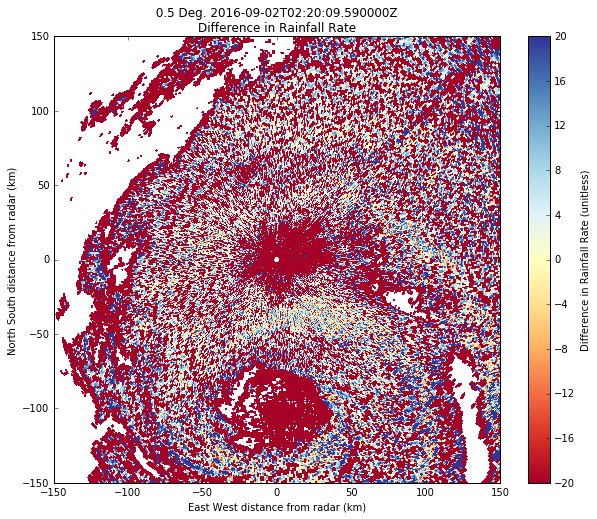

In [60]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('rain_calc_diff', cmap='RdYlBu', vmin=-20, vmax=20, fig=plt.figure(figsize=(10,8)))
display.set_limits((-150, 150), (-150, 150))